## **Environment Setup**
Run all when initiating session

In [ ]:
# retrieve config file, if using colab (nothing should happen if you use Windows)
!cp './drive/My Drive/Live Workspace/generative-facial-cosmetics/model_engineering/config.py' '.'
!mkdir data
!cp -a './drive/My Drive/Live Workspace/generative-facial-cosmetics/model_engineering/data/' '.'
!mkdir models
!cp -a './drive/My Drive/Live Workspace/generative-facial-cosmetics/model_engineering/models/' '.'
!mkdir technical
!cp -a './drive/My Drive/Live Workspace/generative-facial-cosmetics/model_engineering/technical/' '.'
!mkdir trainers
!cp -a './drive/My Drive/Live Workspace/generative-facial-cosmetics/model_engineering/trainers/' '.'
!mkdir utils
!cp -a './drive/My Drive/Live Workspace/generative-facial-cosmetics/model_engineering/utils/' '.'

In [1]:
from config import *                            # config.py
from matplotlib import pyplot as plt 
import os
%matplotlib inline

## **GCS Integration**
Run all when initiating session

In [2]:
if isWindows():
  import utils.gcs_windows as gcs 
elif isColab():
  import utils.gcs_colab as gcs
else:
  raise NotImplementedError('OS is not supported yet')

gcs.init()

#BUCKET1_GS, BUCKET1 = gcs.mount_bucket("ffhq-1024-lips-1")
BUCKET1_GS = BUCKET1 = "C:\\Users\\comtalyst\\Documents\\Local_Workspace\\testdata"

## **Model Environment Setup**

In [3]:
from technical.accelerators import strategy
from data.pipeline import *
from trainers.stylegan import train, load_checkpoint
from models.discriminator import Discriminator
from models.generator import Generator

Running on CPU
Number of accelerators (cores):  1


In [4]:
generator = Generator(strategy)
discriminator = Discriminator(strategy)
current_progress = 0

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 6400)              1644800   
_________________________________________________________________
reshape (Reshape)            (None, 5, 5, 256)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 4)           1028  

In [9]:
##### Load saved models here if not the first generation (SavedModel) #####
RUN = False
# Warning, using this format on colab may cause the "'NoneType' object has no attribute 'get'" bug
if RUN:
  last_epoch = 0
  current_progress = 2
  generator.load(its_progress=current_progress, strategy=strategy, fname="generator" + "-p_" + str(current_progress) + "-e_" + str(last_epoch))
  discriminator.load(its_progress=current_progress, strategy=strategy, fname="discriminator" + "-p_" + str(current_progress) + "-e_" + str(last_epoch))
else:
  print("Running switch for this cell is off, skipping")

Running switch for this cell is off, skipping


In [5]:
##### Load saved models here if not the first generation (checkpoint) #####
RUN = True
# make sure to add progress to the models until reach intended checkpoint's progress
if RUN:
  load_checkpoint(generator, discriminator, strategy)
else:
  print("Running switch for this cell is off, skipping")

Latest checkpoint restored: 6


In [6]:
##### Add progress to models here #####
RUN = True
if RUN:
  generator.progress(strategy)
  discriminator.progress(strategy)
  current_progress += 1
else:
  print("Running switch for this cell is off, skipping")

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          65792       input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          65792       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          65792       dense_1[0][0]                    
____________________________________________________________________________________________

In [7]:
LATENT_SIZE = Generator.LATENT_SIZE 
IMAGE_SHAPE = generator.image_shape
IMAGE_SIZE = [IMAGE_SHAPE[0], IMAGE_SHAPE[0]]
print("Latent size: " + str(LATENT_SIZE))
print("Image shape: " + str(IMAGE_SHAPE))

Latent size: 256
Image shape: (15, 15, 4)


In [8]:
##### Prepare dataset #####
training_dataset = get_dataset(BUCKET1_GS, True, True, True, BUCKET1, image_size=IMAGE_SIZE)

## **Pre-Train Testing**

In [9]:
noise = tf.random.normal([1,LATENT_SIZE])

[[-0.01265245]]


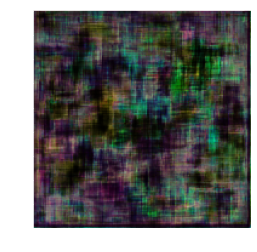

In [15]:
## full model
image = generator.model(noise, training=False)
plt.imshow(image[0])
print(discriminator.model(image, training=False).numpy())

[[0.00536172]]


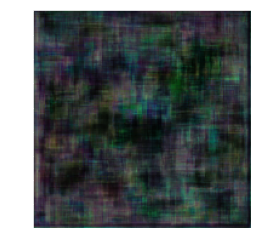

In [17]:
## fading model 
# alpha 0 should be the same as full output from prev generation
# alpha 1 should be the same as full output from current generation
generator.setAlpha(0.5)
image = generator.model_fade(noise, training=False)
plt.imshow(image[0])
print(discriminator.model_fade(image, training=False).numpy())

## **Training**

In [12]:
FADE_EPOCHS = 100
EPOCHS = 200

if isColab():                   # some colab's tpu side bug
  import numpy as np
  np.rank = np.ndim
train(generator, discriminator, training_dataset, FADE_EPOCHS, EPOCHS, BATCH_SIZE, strategy)

## **Saving**

In [13]:
generator.save(0, strategy)
discriminator.save(0, strategy)

INFO:tensorflow:Assets written to: .\outputs\saved_models\current\generator-p_2-e_0\assets
INFO:tensorflow:Assets written to: .\outputs\saved_models\current\discriminator-p_2-e_0\assets


## **Testing**

[[-8.374135]]


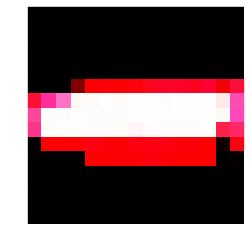

In [8]:
noise = tf.random.normal([1,LATENT_SIZE])
image = generator.model(noise, training=False)
plt.imshow(image[0])
print(discriminator.model(image, training=False).numpy())

## **Experiments**
Just a playground for trying out codes, nothing related at all, do not execute

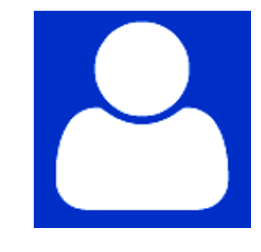

In [143]:
### just code testing

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt 
import os
from PIL import Image
%matplotlib inline

fbytes = tf.io.read_file('avatar.png')
image = tf.image.decode_png(fbytes, channels=4)
max_resize = 0.5
random_scale = max_resize + np.random.rand()*(1 - max_resize)
image = tf.image.central_crop(image, random_scale)
image = Image.fromarray(image.numpy())
image = image.resize((206, 206))
image = tf.convert_to_tensor(np.array(image))
plt.imshow(image)

0.8249300690690824